### Import Resources

In [1]:
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### Create Data

<function matplotlib.pyplot.show(*args, **kw)>

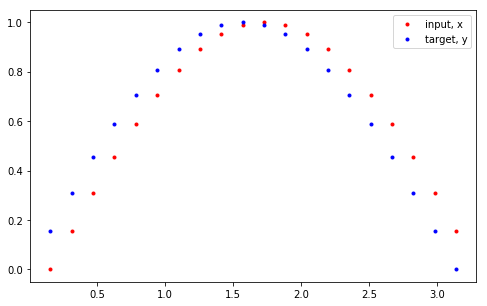

In [2]:
plt.figure(figsize=(8, 5))

# How many time steps/data points are in one batch of data
seq_length = 20

# generate evenly spaced data points
time_steps = np.linspace(0, np.pi, seq_length + 1)
data = np.sin(time_steps)
data.resize(seq_length + 1, 1)
# drop the last data
x = data[:-1]
# drop the first data
y = data[1:]

# Display the data
plt.plot(time_steps[1:], x, 'r.', label = 'input, x')
plt.plot(time_steps[1:], y, 'b.', label = 'target, y')

plt.legend(loc='best')
plt.show

### Define RNN

In [3]:
class RNN(nn.Module):
    def __init__(self, input_size, output_size, hidden_dim, n_layers):
        super(RNN, self).__init__()
        self.hidden_dim = hidden_dim
        # hidden_dim defines howmany features the output of RNN will have
        self.rnn = nn.RNN(input_size, hidden_dim, n_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_size)
    def forward(self, x, hidden):
        # Based on what we define in the model batch_first = True:
        # x is (batch_size, seq_length, input_size)
        # hidden (n_layers, batch_size, hidden_dim)
        # r_out(batch_size, time_step, hidden_size)
        batch_size = x.size(0)
        r_out, hidden = self.rnn(x, hidden)
        r_out = r_out.view(-1, self.hidden_dim)
        output = self.fc(r_out)
        return output, hidden

### Check the input and output dims

In [4]:
test_rnn = RNN(input_size=1, output_size=1, hidden_dim=10, n_layers=2)
# Generate test data
time_steps = np.linspace(0, np.pi, seq_length)
data = np.sin(time_steps)
data.resize(seq_length, 1)
# x is (batch_size, seq_length, input_size)
# batch_size = 1, seq_length = 20, input_size = 1
test_input = torch.Tensor(data).unsqueeze(0)
test_input.size()

torch.Size([1, 20, 1])

In [5]:
test_out, test_h = test_rnn(test_input, None)
# r_out(batch_size, seq_length, output_size)
test_out.size()

torch.Size([20, 1])

In [6]:
# hidden (n_layers, batch_size, hidden_dim)
test_h.size()

torch.Size([2, 1, 10])

### Train the model

In [7]:
# Define hyperparameters
input_size = 1
output_size = 1
hidden_dim = 32
n_layers = 1

rnn = RNN(input_size, output_size, hidden_dim, n_layers)
print(rnn)

RNN(
  (rnn): RNN(1, 32, batch_first=True)
  (fc): Linear(in_features=32, out_features=1, bias=True)
)


### Loss and Optimization

In [8]:
# LOss and optimizer with learning rate 0.01
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(rnn.parameters(), lr = 0.01)

In [9]:
def train(rnn, n_steps, print_every):
    hidden = None
    for batch_i, step in enumerate(range(n_steps)):
        # create data
        time_steps = np.linspace(step*np.pi, (step+1)* np.pi, seq_length + 1)
        data = np.sin(time_steps)
        data.resize(seq_length + 1, 1)
        # create input and output at each step
        x = data[:-1]
        y = data[1:]
        # convert data into Tensors
        x_tensor = torch.Tensor(x).unsqueeze(0)
        y_tensor = torch.Tensor(y)
        
        # outputs from rnn
        prediction, hidden = rnn(x_tensor, hidden)
        # make a new variable at each step and pass the data to the next next state
        hidden = hidden.data
        
        # Calculate the loss 
        loss = criterion(prediction, y_tensor)
        # Zero gradients
        optimizer.zero_grad()
        # Perform backprop and update weights
        loss.backward()
        optimizer.step()
        # display loss and predictions
        if batch_i%print_every == 0:
            print('LOss: ', loss.item())
            plt.plot(time_steps[1:], x, 'r.')
            plt.plot(time_steps[1:], prediction.data.numpy().flatten(), 'b.')
            plt.show()
    return rnn
        

LOss:  0.8114396929740906


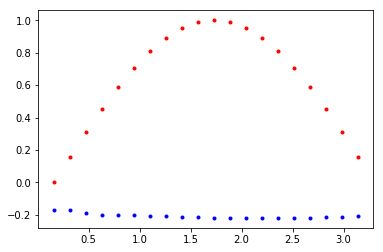

LOss:  0.027975285425782204


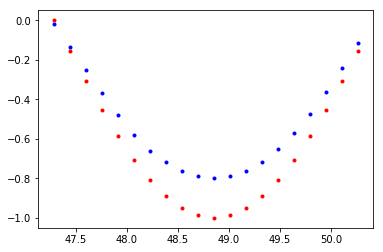

LOss:  0.008839864283800125


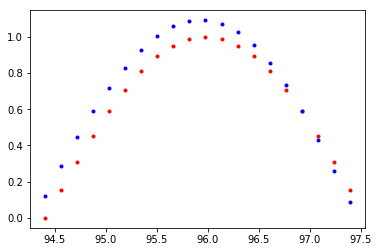

LOss:  0.00013565720291808248


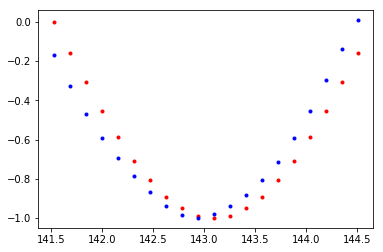

LOss:  0.0009277662611566484


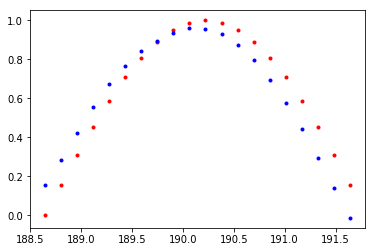

In [10]:
n_steps = 75
print_every = 15
trained_rnn = train(rnn, n_steps, print_every)